# Face Recognition

---
Autor: Vesna Camile Pivac Alcaraz<br>
Curso: Redes Neuronales Profundas<br>
Programa: Maestria en Ciencia de Datos

## Librerias

In [1]:
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.models import model_from_json
from tensorflow.keras import backend as K
K.set_image_data_format('channels_last')
import numpy as np
from typing import Union, AnyStr
import json

In [2]:
print("Tensorflow: ",tf.__version__)
print("Tensorflow-Keras: ",tf.keras.__version__)
print(tf.config.list_physical_devices())
!python --version

Tensorflow:  2.3.0
Tensorflow-Keras:  2.4.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]
Python 3.7.6


## Modelo

In [4]:
json_file = open('./model/model.json','r')
loaded_model_json = json_file.read()
json_file.close()

In [5]:
model = model_from_json(loaded_model_json)
model.load_weights('./model/model.h5')

In [6]:
FRmodel = model

### Inputs y Outputs del modelo

In [7]:
print(model.inputs)
print(model.outputs)

[<tf.Tensor 'input_1:0' shape=(None, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm/batchnorm/add_1:0' shape=(None, 128) dtype=float32>]


## Funciones

In [8]:
# UNQ_C1(UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: triplet_loss

def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss as defined by formula (3)

    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 128)
            positive -- the encodings for the positive images, of shape (None, 128)
            negative -- the encodings for the negative images, of shape (None, 128)

    Returns:
    loss -- real number, value of the loss
    """

    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]

    # Compute the (encoding) distance between the anchor and the positive
    pos_dist =  tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis=-1)
    # Compute the (encoding) distance between the anchor and the negative
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis=-1)
    # Subtract the two previous distances and add alpha.
    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)
    # Take the maximum of basic_loss and 0.0. Sum over the training examples.
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0))

    return loss

In [9]:
def verify(image_path, identity, database, model):
    """
    Function that verifies if the person on the "image_path" image is "identity".

    Arguments:
        image_path -- path to an image
        identity -- string, name of the person you'd like to verify the identity. Has to be an employee who works in the office.
        database -- python dictionary mapping names of allowed people's names (strings) to their encodings (vectors).
        model -- your Inception model instance in Keras

    Returns:
        dist -- distance between the image_path and the image of "identity" in the database.
        door_open -- True, if the door should open. False otherwise.
    """
    ### START CODE HERE
    # Step 1: Compute the encoding for the image. Use img_to_encoding() see example above. (≈ 1 line)
    encoding =  img_to_encoding(image_path, model)
    # Step 2: Compute distance with identity's image (≈ 1 line)
    dist = np.linalg.norm(encoding - database[identity])
    # Step 3: Open the door if dist < 0.7, else don't open (≈ 3 lines)
    if dist<0.7:
        print("It's " + str(identity) + ", welcome in!")
        door_open = True
    else:
        print("It's not " + str(identity) + ", please go away")
        door_open = False
    ### END CODE HERE
    return dist, door_open

In [10]:
def preprocess_image(image: Union[np.ndarray, AnyStr], 
                     shape=(160,160)) -> np.ndarray:
    if isinstance(image, np.ndarray):
        img = tf.keras.preprocessing.image.smart_resize(
            img, shape)
    # If image is path
    else:
        img = tf.keras.preprocessing.image.load_img(
            image, target_size=(160, 160))
        img = np.array(img)
    return img

def img_to_encoding(img: Union[np.ndarray, str], 
                    model) -> np.ndarray:
    if isinstance(img, str):
        img = preprocess_image(img)

    img = np.around(img / 255.0, decimals=12)
    x_train = np.expand_dims(img, axis=0)
    embedding = model.predict_on_batch(x_train)

    return embedding / np.linalg.norm(embedding, ord=2)

In [11]:
def who_is_it(image_path, database, model):
    """
    Implements face recognition for the office by finding who is the person on the image_path image.

    Arguments:
        image_path -- path to an image
        database -- database containing image encodings along with the name of the person on the image
        model -- your Inception model instance in Keras

    Returns:
        min_dist -- the minimum distance between image_path encoding and the encodings from the database
        identity -- string, the name prediction for the person on image_path
    """

    ## Compute the target "encoding" for the image. Use img_to_encoding() see example above. ## (≈ 1 line)
    encoding =   img_to_encoding(image_path, model)

    ## Find the closest encoding ##

    # Initialize "min_dist" to a large value, say 100 (≈1 line)
    min_dist = 100

    # Loop over the database dictionary's names and encodings.
    for (name, db_enc) in database.items():

        # Compute L2 distance between the target "encoding" and the current db_enc from the database. (≈ 1 line)
        dist =  np.linalg.norm(encoding - db_enc)

        # If this distance is less than the min_dist, then set min_dist to dist, and identity to name. (≈ 3 lines)
        if dist<min_dist:
            min_dist = dist
            identity = name

    if min_dist > 0.7:
        print("Not in the database.")
    else:
        print ("it's " + str(identity) + ", the distance is " + str(min_dist))

    return min_dist, identity

## Dataset

In [12]:
database = {}
database['Vesna'] = img_to_encoding('images/vesna.png', FRmodel).tolist()
database['Estephania'] = img_to_encoding('images/estephania.png', FRmodel).tolist()
database['Danisa'] = img_to_encoding('images/danisa.jpg', FRmodel).tolist()

In [21]:
vesna = tf.keras.preprocessing.image.load_img("images/vesna.png", target_size=(160, 160))
danisa = tf.keras.preprocessing.image.load_img("images/danisa.jpg", target_size=(160, 160))

In [22]:
np.around(np.array(vesna) / 255.0, decimals=12).shape

(160, 160, 3)

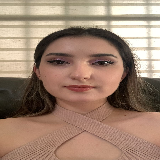

In [23]:
vesna

In [24]:
np.around(np.array(danisa) / 255.0, decimals=12).shape

(160, 160, 3)

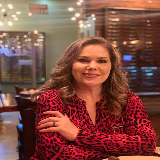

In [25]:
danisa

### Pruebas

In [28]:
verify("images/imagen-023.jpg", "Danisa", database, FRmodel)

It's not Danisa, please go away


(1.291728240285002, False)

In [29]:
verify("images/imagen-023.jpg", "Vesna", database, FRmodel)

It's Vesna, welcome in!


(0.3001721991567347, True)

In [31]:
who_is_it("images/imagen-023.jpg", database, FRmodel)

it's Vesna, the distance is 0.3001721991567347


(0.3001721991567347, 'Vesna')

### Creación del dataset como json

In [15]:
with open('database.json', 'w') as outfile:
    json.dump(database, outfile, indent=4)